### Файл `main.ipynb`
Тетрадка с кодом применения
модели, которая при запуске Run без
дополнительных модификаций должна считывать
предоставленную на github тестовую выборку
test.xlsx и добавлять в
test.xlsx колонку с прогнозом целого числа N (на сколько недель вперед
необходимо проводить закупку) для каждой даты, присутствующей в test.

### Клон репозитория

In [1]:
!git clone https://github.com/samoletpanfilov/reinforcement_task.git

Cloning into 'reinforcement_task'...
remote: Enumerating objects: 18, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 18 (delta 3), reused 18 (delta 3), pack-reused 0 (from 0)
Receiving objects: 100% (18/18), 278.37 KiB | 4.72 MiB/s, done.
Resolving deltas: 100% (3/3), done.


### Установка зависимостей

In [2]:
!pip install tsfresh gdown

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.0/96.0 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 45.0 MB/s eta 0:00:00


### Импорт библиотек

In [5]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from tsfresh import extract_features, extract_relevant_features, select_features
from tsfresh.utilities.dataframe_functions import impute
from tsfresh.feature_extraction import settings

import xgboost as xgb

import pickle
import gdown

%matplotlib inline
from matplotlib import pyplot as plt

import warnings
warnings.filterwarnings('ignore')

USE_LOCAL=False

### Загрузка данных

In [6]:
url = "https://drive.google.com/drive/folders/1nJZpyxfemM-QwcnsJgdSlEWHGkYH78Cm?usp=sharing"
if not USE_LOCAL:
    gdown.download_folder(url, quiet=False, use_cookies=False)

Retrieving folder contents


Retrieving folder 1WOE0meBlVW7435cEzSMYV3qrYkAf6q9X metamodel
Processing file 1cdrwrK5mLBpjrfSD_hLT2W8RpYnzvRsd cb_model_1.cbm
Processing file 1dgUgUNzHyPqBa9XlwT7oGW7enrGi4XrK cb_model_2.cbm
Processing file 1I24pImgbOoWMwkrRFnUIIMurLJ8n4FOC cb_model_3.cbm
Processing file 1_acv3ce2Wyu_FMoEzRAYWEh6JVMK8piv cb_model_4.cbm
Processing file 1GrUac_STOCA7qVUY0xgY3P2tmrCTEcnA cb_model_5.cbm
Processing file 10FBt1VhJ-kfvAlJC-s_3ywVvV6VVM5B8 cb_model_6.cbm
Processing file 13OR5M8vHQisS1HGz381Gvv9rPKido9aT cb_model_7.cbm
Processing file 16w1X2isZ8lRkhOTvkyew3EPNi-wzdiCU cb_model_8.cbm
Processing file 1QQiNWVXNaQ4Hx9XN4yPHimNtH7zb9Me0 cb_model_9.cbm
Processing file 1xxxsBt3QhZfQMJPdH9cZcDsvOGG2QH9m metamodel.mmm
Processing file 1KYXjI6AplQmS2EjaCJiCYR9whFS84hj3 columns_with_high_nan.txt
Processing file 1NwnQKUW2xSLo-QT7W2D2jf6sXxwIye4s sarima_model.pkl
Processing file 1FpK5aYYeFcXmLcXqAVWRBWeLC4ybglgR xgb_reg1.pkl
Processing file 1BBdcn8aFLONfJLp1sMcZ1IYsTQn1VD5r xgb_reg2.pkl
Processing file 1YX_

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=1cdrwrK5mLBpjrfSD_hLT2W8RpYnzvRsd
To: /content/models/metamodel/cb_model_1.cbm
100%|██████████| 1.17M/1.17M [00:00<00:00, 125MB/s]
Downloading...
From: https://drive.google.com/uc?id=1dgUgUNzHyPqBa9XlwT7oGW7enrGi4XrK
To: /content/models/metamodel/cb_model_2.cbm
100%|██████████| 1.17M/1.17M [00:00<00:00, 120MB/s]
Downloading...
From: https://drive.google.com/uc?id=1I24pImgbOoWMwkrRFnUIIMurLJ8n4FOC
To: /content/models/metamodel/cb_model_3.cbm
100%|██████████| 1.17M/1.17M [00:00<00:00, 121MB/s]
Downloading...
From: https://drive.google.com/uc?id=1_acv3ce2Wyu_FMoEzRAYWEh6JVMK8piv
To: /content/models/metamodel/cb_model_4.cbm
100%|██████████| 1.17M/1.17M [00:00<00:00, 135MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GrUac_STOCA7qVUY0xgY3P2tmrCTEcnA
To: /content/models/metamodel/cb_model_5.cbm
100%|██████████| 1.17M/1.17M [00

In [9]:
train = pd.read_excel("/content/reinforcement_task/data/train.xlsx")
test = pd.read_excel("/content/reinforcement_task/data/test.xlsx")

model0 = pickle.load(open("models/xgb_reg1.pkl", "rb"))
model1 = pickle.load(open("models/xgb_reg2.pkl", "rb"))
model2 = pickle.load(open("models/xgb_reg3.pkl", "rb"))

### Предобработка данных

In [10]:
# Подготовка тренировочной выборки
df_train = pd.DataFrame()
df_train['Date'] = pd.to_datetime(train['dt'])
df_train['Price'] = train['Цена на арматуру']
df_train['istest'] = 0

# Подготовка тестовой выборки
df_test = pd.DataFrame()
df_test['Date'] = pd.to_datetime(test['dt'])
df_test['Price'] = test['Цена на арматуру']
df_test['istest'] = 1

# Конкатинируем в один датасет с метрой `istest`
raw = pd.concat((df_train, df_test)).reset_index(drop=True)

# Выделяем временные признаки
raw["day_sin"] = np.sin(raw["Date"].dt.day)
raw["day_cos"] = np.cos(raw["Date"].dt.day)

# Создадим матрицы со сдвигом, то есть сделаем так, чтобы значение
# цены на следующую неделю являлось "неизвестным для модели"
X = raw.drop(columns=['Price']).iloc[:-1, :]
y = raw['Price'].values[1:]

X['Price_target'] = y
X['Price_source'] = raw['Price'].values[:-1]

# Подсчитаем разницу между текущим и прошлым значением цены на покупку арматуры
price_diff = X['Price_source'] - X['Price_target']

# Удаляем первую строку
X = X.drop([0])

# Добавляем разницу в цене
X['Price_Diff'] = price_diff.values[:-1]

# Удаление ненужных столбцов
y = X['Price_target']
X = X.drop(columns=['Price_target', 'Date'])

In [11]:
# Используем следующий набор параметров

# Рассчитываются коэффициенты skewness и kurtosis, считается, сколько раз
# повторялось значение минимума и максимума, различные квантили, оконные
# статистики, автокорреляции и т. д.
settings_efficient = settings.EfficientFCParameters()
len(settings_efficient)

# Подготовка фреймов длины 5
data_fot_tsfresh = X['Price_source'].values
indexes = list(range(len(data_fot_tsfresh), 4, -1))

ts_for_tsfresh = []

for i in range(len(indexes)):
    indexes_ts = indexes[i:i+6][::-1]
    values_ts = data_fot_tsfresh[indexes_ts[0]:indexes_ts[-1]]
    # print(values_ts)
    if len(values_ts) < 5:
        break
    ts_for_tsfresh.append(values_ts)

ts_for_tsfresh = pd.DataFrame(ts_for_tsfresh[::-1])

# Создание фрейма необходимого формата для выделения признаков
data_long = pd.DataFrame({'data': ts_for_tsfresh.values.flatten(),
              'id': np.repeat(np.array(ts_for_tsfresh.index), 5)})

# Генерация признаков
X_tsfresh = extract_features(data_long, column_id='id', impute_function=impute, default_fc_parameters=settings_efficient)

# Удаление пустых строк
X = X.drop(list(range(1, 10)))
y = y.drop(list(range(1, 10)))

# Reset индексов
X = X.reset_index(drop=True)
y = y.reset_index(drop=True)

# Добавляем выделенные признаки в тренировочную и тестовую выборки
for col in X_tsfresh.columns:
    X[col] = X_tsfresh[col]

Feature Extraction: 100%|██████████| 417/417 [00:36<00:00, 11.35it/s]


### Прогнозирование временного ряда для тестовой выборки

In [12]:
data_for_test = X[X['istest'] == 1]
data_for_test = data_for_test.drop(columns=['istest'])

ypred = (model0.predict(data_for_test) +
         model1.predict(data_for_test) +
         model2.predict(data_for_test)) / 3

In [13]:
result = pd.DataFrame({'real': y[X['istest'] == 1][1:],
              'pred': ypred[:-1]})
result['error'] = result['real'] - result['pred']
result.tail(12)

,real,pred,error
405,42500,41506.910156,993.089844
406,42700,42037.425781,662.574219
407,42700,45183.160156,-2483.160156
408,42700,45848.531250,-3148.531250
409,42800,44831.503906,-2031.503906
410,42800,43877.343750,-1077.343750
411,44500,44917.894531,-417.894531
412,44500,45649.250000,-1149.250000
413,46000,46594.046875,-594.046875
414,49200,47489.527344,1710.472656


In [14]:
# Подсчет метрик прогноза на отложенной выборке
print("MAE на тестовой выборке:", mean_absolute_error(y[X['istest'] == 1], ypred))
print("MSE на тестовой выборке:", mean_squared_error(y[X['istest'] == 1], ypred))
print("RMSE на тестовой выборке:", np.sqrt(mean_squared_error(y[X['istest'] == 1], ypred)))
print("R^2 на тестовой выборке:", r2_score(y[X['istest'] == 1], ypred))

MAE на тестовой выборке: 1294.11669921875
MSE на тестовой выборке: 2604567.75
RMSE на тестовой выборке: 1613.8673272608253
R^2 на тестовой выборке: 0.8023148775100708


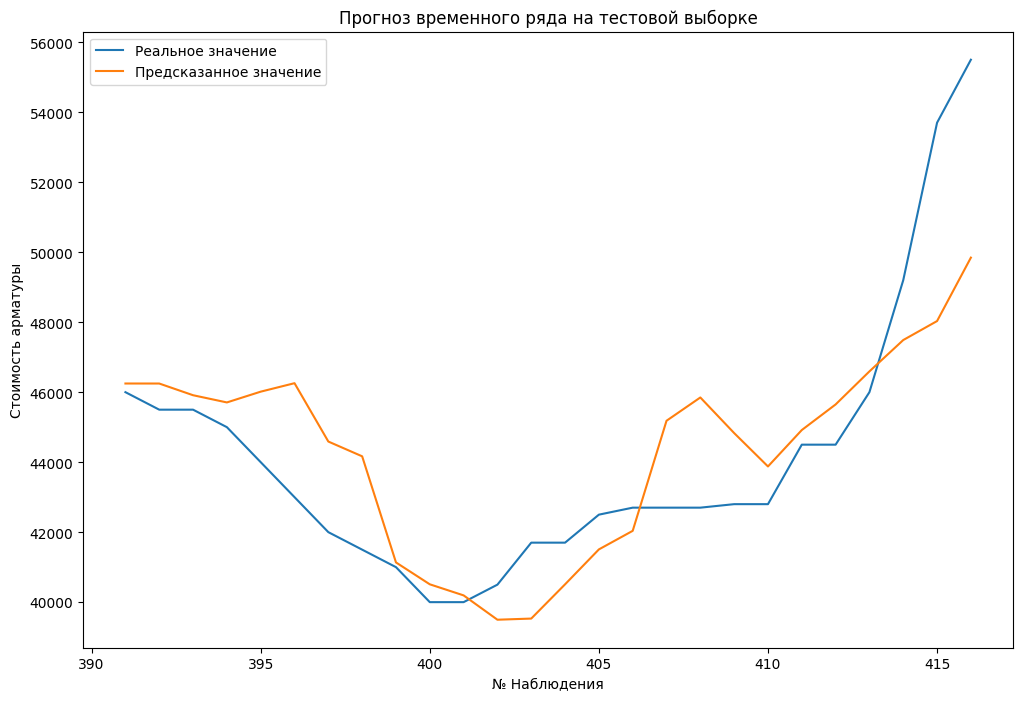

In [17]:
from matplotlib.pyplot import figure
figure(figsize=(12, 8), dpi=100)


plt.plot(result['real'], label='Реальное значение');
plt.plot(result['pred'], label='Предсказанное значение');
plt.title('Прогноз временного ряда на тестовой выборке')
plt.xlabel('№ Наблюдения')
plt.ylabel('Стоимость арматуры')
plt.legend();

# Распределение объема закупок арматуры по предсказанным значениям ряда

In [18]:
# Функция для распределения объема закупок
def get_minimum_spend(data):
    values = data.iloc[:, 1].astype(float)
    markers = []
    pos = 0
    total = 0
    while pos < len(values):
        temp = np.diff(values[pos:pos+10])
        temp = np.insert(temp, 0, np.nan)
        temp[1:] = np.cumsum(temp[1:])
        counter = 0
        for counter in range(len(temp)):
            counter += 1
            if pos + counter == len(values):
                break
            if counter == len(temp):
                break
            if temp[counter] < 0:
                break
        markers.append(counter)
        markers.extend([0 for _ in range(counter-1)])
        total += counter * values[pos]
        pos += counter
    return(markers, total)

In [19]:
source_price = test['Цена на арматуру']
predictions_costs = pd.DataFrame(np.array(list(y[X['istest'] == 0].tail(1).values) + list(ypred)))
test['Цена на арматуру'] = predictions_costs

In [20]:
# Потраченная сумма на арматуру
markers, total = get_minimum_spend(test)

In [21]:
test['Объем'] = markers
print("Общая сумма затрат, учитывая прогноз цены: ", total)

Общая сумма затрат, учитывая прогноз цены:  1200500.7734375


In [22]:
test['Цена на арматуру'] = source_price
test.to_excel("submission.xlsx", index=False)
test

,dt,Цена на арматуру,Объем
0,2022-09-05,46000,3
1,2022-09-12,46000,0
2,2022-09-19,46000,0
3,2022-09-26,45500,1
4,2022-10-03,45500,3
5,2022-10-10,45000,0
6,2022-10-17,44000,0
7,2022-10-24,43000,1
8,2022-10-31,42000,1
9,2022-11-07,41500,1


In [23]:
def decision_prices(test):

    test = test.set_index('dt')
    tender_price = test['Цена на арматуру']
    decision = test['Объем']
    start_date = test.index.min()
    end_date = test.index.max()

    _results = []
    _active_weeks = 0
    for report_date in pd.date_range(start_date, end_date, freq='W-MON'):
        if _active_weeks == 0:  # Пришла пора нового тендера
            _fixed_price = tender_price.loc[report_date]
            _active_weeks = int(decision.loc[report_date])
        _results.append(_fixed_price)
        _active_weeks += -1
    cost = sum(_results)
    return cost # Возвращаем затраты на периоде

In [24]:
print("Общая сумма затрат, учитывая знание цены на арматуру: ", decision_prices(test))

Общая сумма затрат, учитывая знание цены на арматуру:  1194500


In [25]:
test = test.drop(columns=['Объем'])

# "Идеальный" вариант
markers, total = get_minimum_spend(test)

In [26]:
test['Объем'] = markers
test

,dt,Цена на арматуру,Объем
0,2022-09-05,46000,3
1,2022-09-12,46000,0
2,2022-09-19,46000,0
3,2022-09-26,45500,2
4,2022-10-03,45500,0
5,2022-10-10,45000,1
6,2022-10-17,44000,1
7,2022-10-24,43000,1
8,2022-10-31,42000,1
9,2022-11-07,41500,1
